In [75]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import astropy.constants as aconst
from pycbc.filter import sigmasq
from pycbc import waveform
from calcwf import chirp2total, gen_wf, ceiltwo, gen_psd, shifted_e
from scipy.optimize import minimize
import os
import pickle

# Attempt 1

In [2]:
def shifted_e_const(f, e):
    """
    Calculates constant of proportionality between gw frequency and function of eccentricity.

    Parameters:
        f: Gravitational wave frequency.
        e: Eccentricity.

    Returns:
        Proportionality constant.
    """

    constant = f*e**(18/19)*(1+(121/304)*e**2)**(1305/2299)*(1-e**2)**(-3/2)

    return constant

def total2f_ISCO(M):
    """
    Converts total mass of BBH to gravitational wave frequency at ISCO (approximated by assuming 
    circular, non-spinning).

    Parameters:
        M: Total mass.

    Returns:
        Gravitiational wave frequency at ISCO.
    """

    f_ISCO = const.c**3/(6*np.sqrt(6)*np.pi*const.G*M*aconst.M_sun.value)

    return f_ISCO

def const_eff_chirp_favata(given_e, given_chirp, e_vals, f_low=10, q=2, average_f=True, shift_e='approx', ISCO_upper=False):
    """
    Converts array of eccentricity values to chirp mass along a line of constant 
    effective chirp mass, as given by equation 1.1 in Favata et al. 
    https://arxiv.org/pdf/2108.05861.pdf.

    Parameters:
        given_e: Value of eccentricity for given point on line of constant effective chirp mass.
        given_chirp: Value of chirp mass for given point on line of constant effective chirp mass.
        e_vals: Frequency values to be converted.

    Returns:
        Converted chirp mass values.
    """

    # Find average value of f and evolve eccentricities if required
    if average_f:

        # Generate waveform at given point to use in sigmasq
        h = gen_wf(f_low, given_e, chirp2total(given_chirp, q), q, 4096, 'TEOBResumS')
        h.resize(ceiltwo(len(h)))
        
        # Generate the aLIGO ZDHP PSD
        psd, _ = gen_psd(h, f_low)

        # Sets upper bound of f_ISCO if requested
        if ISCO_upper:
            high_frequency_cutoff = total2f_ISCO(chirp2total(given_chirp, 2))
        else:
            high_frequency_cutoff = None

        # Calculate both integrals using sigmasq
        h = h.real().to_frequencyseries()
        ss = sigmasq(h, psd=psd, low_frequency_cutoff=f_low+3, high_frequency_cutoff=high_frequency_cutoff)
        ssf = sigmasq(h*np.sqrt(h.sample_frequencies), psd=psd, low_frequency_cutoff=f_low+3, 
                      high_frequency_cutoff=high_frequency_cutoff)

        # Use average frequency to evolve eccentricities
        avg_f = ssf/ss
        print('Average frequency: '+str(avg_f)+' Hz')
        if shift_e == 'approx':
            s_given_e = shifted_e(avg_f, f_low, given_e)
            print(f'Given_e shifted from {given_e} to {s_given_e}')
            s_e_vals = shifted_e(avg_f, f_low, e_vals)
        elif shift_e == 'exact':
            # For given_e
            constant = shifted_e_const(f_low, given_e)
            init_guess = shifted_e(avg_f, f_low, given_e)
            bounds = [(0, 0.999)]
            best_fit = minimize(lambda x: abs(shifted_e_const(avg_f, x)-constant), init_guess, bounds=bounds)
            s_given_e = np.array(best_fit['x'])
            print(f'Given_e shifted from {given_e} to {s_given_e}')
            # For e_vals
            constant = shifted_e_const(f_low, e_vals)
            init_guess = np.full(len(e_vals), shifted_e(avg_f, f_low, e_vals))
            bounds = [(0, 0.999)]
            best_fit = minimize(lambda x: np.sum(abs(shifted_e_const(avg_f, x)-constant)), init_guess, bounds=bounds)
            s_e_vals = np.array(best_fit['x'])
        else:
            raise Exception('shift_e not recognised')
    else:
        s_given_e = given_e
        s_e_vals = e_vals

    # Find effective chirp mass of given point
    eff_chirp = given_chirp/(1-(157/24)*s_given_e**2)**(3/5)

    # Convert to chirp mass values
    chirp_vals = eff_chirp*(1-(157/24)*s_e_vals**2)**(3/5)

    return chirp_vals

def eff_chirp_bose(chirp, e):
    """
    Calculates the effective chirp mass parameter defined by Bose and Pai (2021).

    Parameters:
        chirp: chirp mass in solar masses.
        e: eccentricity at 10Hz.

    Returns:
        Effective chirp mass parameter in solar masses.
    """

    # Define polynomial constants
    epsilon = 0.06110974175360381
    delta = -0.4193723077257345
    Theta_beta = 0.00801015132110059
    Delta_beta = -2.14807199936756*10**-5
    kappa_beta = 1.12702400406416*10**-8
    zeta_beta = -1.9753003183066*10**-12
    Theta_gamma = 0.024204222771565382
    Delta_gamma = -6.261945897154536*10**-6
    kappa_gamma = 1.1175104924576945*10**-8
    zeta_gamma = -3.681726165703978*10**-12

    # Coefficient of e_10^2
    alpha = epsilon*chirp + delta

    # Coefficient of e_10^4
    beta = Theta_beta*chirp**2 + Delta_beta*chirp**2 + kappa_beta*chirp**6 + zeta_beta*chirp**8

    # Coefficient of e_10^6
    gamma = Theta_gamma*chirp**2 + Delta_gamma*chirp**2 + kappa_gamma*chirp**6 + zeta_gamma*chirp**8

    # Effective chirp mass
    eff_chirp = chirp*(1 + alpha*e**2 + beta*e**4 + gamma*e**6)

    return eff_chirp
    
def const_eff_chirp_bose(given_e, given_chirp, e_vals):
    """
    Converts array of eccentricity values to chirp mass along a line of constant 
    effective chirp mass, as given by equation 7 in Bose and Pai (2021) 
    https://arxiv.org/pdf/2107.14736.pdf.

    Parameters:
        given_e: Value of eccentricity for given point on line of constant effective chirp mass.
        given_chirp: Value of chirp mass for given point on line of constant effective chirp mass.
        e_vals: Frequency values to be converted.

    Returns:
        Converted chirp mass values.
    """

    # Find effective chirp mass of given point
    eff_chirp = eff_chirp_bose(given_chirp, given_e)

    # Optimise to find chirp mass values corresponding to eccentricity values
    init_guess = np.full(len(e_vals), given_chirp)
    best_fit = minimize(lambda x: np.sum(abs(eff_chirp_bose(x, e_vals)-eff_chirp)), init_guess)
    chirp_vals = np.array(best_fit['x'])
    
    return chirp_vals

In [3]:
e_vals = np.linspace(0,0.2,100)
chirp_vals_b = const_eff_chirp_bose(0.1, 24, e_vals)
chirp_vals_f = const_eff_chirp_favata(0.1, 24, e_vals, average_f=False)

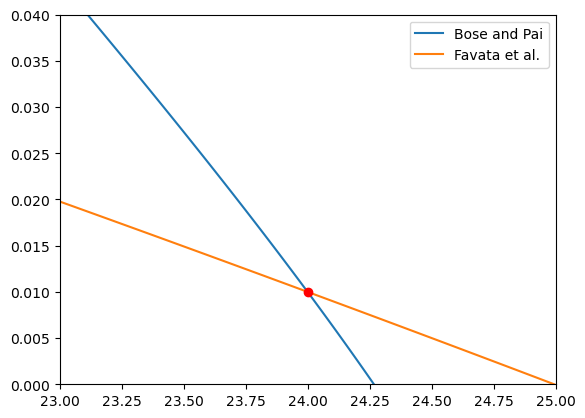

In [4]:
plt.plot(chirp_vals_b, e_vals**2, label='Bose and Pai')
plt.plot(chirp_vals_f, e_vals**2, label='Favata et al.')
plt.scatter(24, 0.1**2, c='r', zorder=5)
plt.xlim(23,25)
plt.ylim(0,0.04)
plt.legend()

Neither line is able to describe the degeneracy we find in our e^2 against chirp mass plots well. We will try to calculate a weighted average of the frequency, and evolve the ecccentricity to this stage in order to input into the favata et al. equation. Can do this by defining:

\begin{equation}
\overline{f} = \frac{4 \Re \int df \frac{f |h(f)|^2}{S(f)}}{4 \Re \int df \frac{|h(f)|^2}{S(f)}}
\end{equation}
This can be achieved with the sigmasq function of pycbc: first inputting $h(f)$ to get the denominator, and then $\sqrt{f}\cdot h(f)$ for the numerator. We can then translate eccentricities we input into the favata et al. function from $e(f_{10})$ to $e(\overline{f})$, and see whether this improves the resulting degeneracy line.

In [5]:
chirp_vals_avg_f = const_eff_chirp_favata(0.1, 24, e_vals, f_low=10, q=2, average_f=True)

Average frequency: 82.71992022152772 Hz
Given_e shifted from 0.1 to 0.010750076475934445


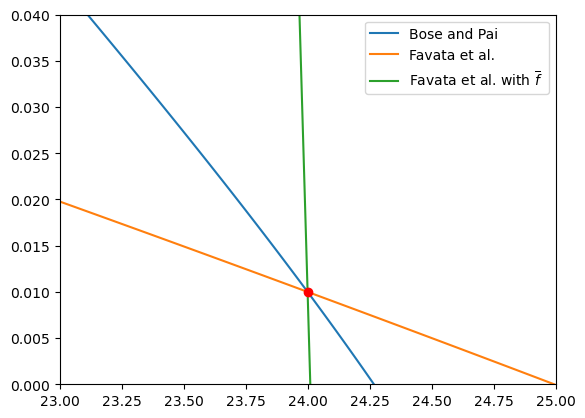

In [6]:
plt.plot(chirp_vals_b, e_vals**2, label='Bose and Pai')
plt.plot(chirp_vals_f, e_vals**2, label='Favata et al.')
plt.plot(chirp_vals_avg_f, e_vals**2, label='Favata et al. with $\overline{f}$')
plt.scatter(24, 0.1**2, c='r', zorder=5)
plt.xlim(23,25)
plt.ylim(0,0.04)
plt.legend()

Would the orbit actually evolve to this high of a frequency of 83Hz? Innermost stable circular orbit of a black hole is at $r_{\mathrm{ISCO}} = 6M$, so assume merger happens here. Can find gravitational wave frequency as twice the orbital frequency at this radius.

In [7]:
r_isco = 6*const.G*chirp2total(24,2)*aconst.M_sun.value/const.c**2
orb_period = np.sqrt((4*np.pi**2*r_isco**3)/(const.G*chirp2total(24,2)*aconst.M_sun.value))
f_gw = 2/orb_period
print(f_gw)

74.30789804011728


It is very close so do not trust the equation I have used to evolve the eccentricity this high - additionally believe it is only accurate for small changes in eccentricity/frequency which is clearly not the case here.

From Maggiore (page 187), we have:

\begin{equation}
\frac{da}{de} = \frac{12}{19} a \frac{1+(73/24)e^2+(37/96)e^4}{e(1-e^2)[1+(121/304)e^2]}
\end{equation}

which when integrated analytically gives

\begin{equation}
a(e) = c_0\frac{e^{12/19}}{1-e^2} \left(1+\frac{121}{304}e^2 \right)^{870/2299}
\end{equation}

Changing from $a(e)$ to $f_{\mathrm{GW}}$, we get

\begin{equation}
f_{GW} = d_0 \frac{(1-e^2)^{3/2}}{e^{18/19}} \left(1+\frac{121}{304}e^2 \right)^{-1305/2299}
\end{equation}

By taylor expanding around $e \ll 1$, we recover the familiar equation that we had been using

\begin{equation}
e = e_0 \left(\frac{f_{\mathrm{GW}}}{f_0} \right)^{-19/18}
\end{equation}

Will therefore try the exact equation to evolve the frequency. Obviously cannot solve for $e$ here, so will use optimisation with scipy again.

In [8]:
chirp_vals_exact_f = const_eff_chirp_favata(0.1, 24, e_vals, f_low=10, q=2, average_f=True, shift_e='exact')

Average frequency: 82.71992022152772 Hz
Given_e shifted from 0.1 to [0.01094614]


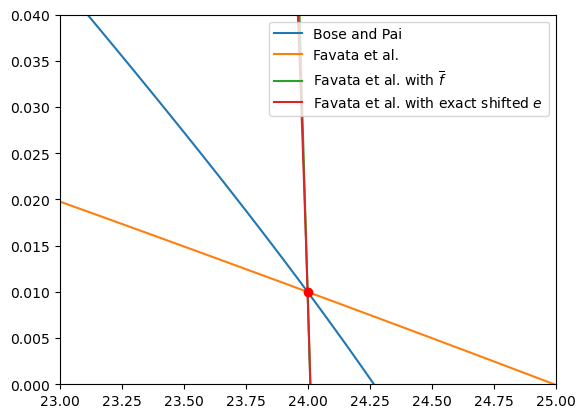

In [9]:
plt.plot(chirp_vals_b, e_vals**2, label='Bose and Pai')
plt.plot(chirp_vals_f, e_vals**2, label='Favata et al.')
plt.plot(chirp_vals_avg_f, e_vals**2, label='Favata et al. with $\overline{f}$')
plt.plot(chirp_vals_exact_f, e_vals**2, label='Favata et al. with exact shifted $e$')
plt.scatter(24, 0.1**2, c='r', zorder=5)
plt.xlim(23,25)
plt.ylim(0,0.04)
plt.legend()

This makes almost negligible difference to shape of line, so has no advantage over the more approximate equation. Furthermore, I still doubt the validity of the equation as it is shifting to above the ISCO frequency.

Another idea I want to try is to set upper bound of integral when calculating $\overline{f}$ to the ISCO frequency. Will use the following equation (cleaned up/simplified version of code above):

\begin{equation}
f_{\mathrm{ISCO}} = \frac{1}{6\sqrt{6}\pi}\frac{c^3}{Gm}
\end{equation}

In [10]:
chirp_vals_ISCO_upper_f = const_eff_chirp_favata(0.1, 24, e_vals, f_low=10, q=2, average_f=True, ISCO_upper=True)

Average frequency: 42.52521765110796 Hz
Given_e shifted from 0.1 to 0.021698446760048763


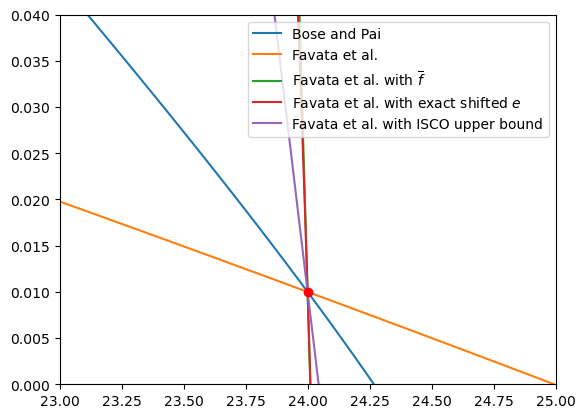

In [11]:
plt.plot(chirp_vals_b, e_vals**2, label='Bose and Pai')
plt.plot(chirp_vals_f, e_vals**2, label='Favata et al.')
plt.plot(chirp_vals_avg_f, e_vals**2, label='Favata et al. with $\overline{f}$')
plt.plot(chirp_vals_exact_f, e_vals**2, label='Favata et al. with exact shifted $e$')
plt.plot(chirp_vals_ISCO_upper_f, e_vals**2, label='Favata et al. with ISCO upper bound')
plt.scatter(24, 0.1**2, c='r', zorder=5)
plt.xlim(23,25)
plt.ylim(0,0.04)
plt.legend()

This is closer but still not quite right. I could likely keep on going making 'random' changes until I get something that looks right, however has no physical justification/basis, and would likely not work for other parameters. I believe that the problem with the current $\overline{f}$ may be twofold. Firstly, as previously explored, $\overline{f} > f_{\mathrm{ISCO}}$, and so the orbital evolution equation cannot be used to calculate the corresponding eccentricity. Secondly, the power in the signal at each frequency may not necessarily uniquely determine the ability to differentiate eccentricity and chirp mass - it is possible that different phases of the signal may give more or less information in this regard, so this may not be quite the right metric to weight by when calculating $\overline{f}$.

# Attempt 2

First off let's try and work out what value of frequency/eccentricity would make the Favata et al. equation agree with the line of degeneracy we observe. We will do this by inputting different values of frequency to see which fits our line the best. This requires the construction of a line representing our line of degeneracy, which will not be perfect, but sufficient to obtain an estimate.

First let's construct our 'correct' line of degeneracy. We require two points to define it fully, the first will be the fiducial ($e_{10} = 0.1$, chirp = 24) point, and the second we must estimate by eye.

In [28]:
def line_2_points(y_vals,x1,y1,x2,y2):

    xy_slope = (x2-x1)/(y2-y1)
    x_intercept = x1 - xy_slope*y1
    x_vals = xy_slope*y_vals + x_intercept

    return x_vals

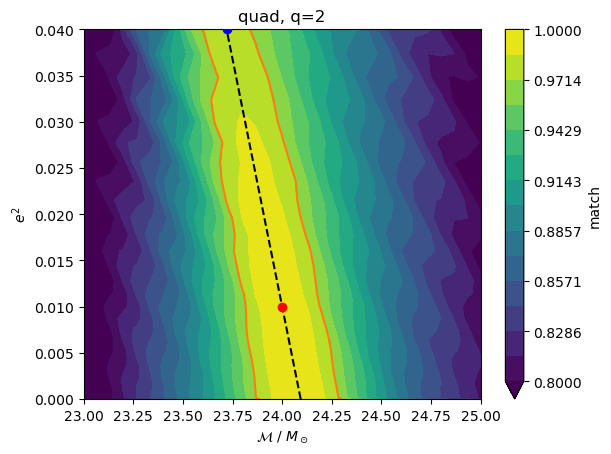

In [58]:
x1, y1 = 24, 0.1**2
x2, y2 = 23.72, 0.2**2
e_line_vals = np.linspace(0,0.2,100)
chirp_line_vals = line_2_points(e_line_vals**2, x1, y1, x2, y2)

with open(os.path.join('e_sqrd_chirp_data', 'dataslot_6'), 'rb') as fp:
        data = pickle.load(fp)
plt.contourf(np.linspace(23, 25, 31), np.linspace(0, 0.2, 31)**2, data['quad'], np.linspace(0.8, 1, 15), vmin=0.8, vmax=1, extend='min')
plt.colorbar(label='match')
plt.contour(np.linspace(23, 25, 31), np.linspace(0, 0.2, 31)**2, data['quad'], [0.97], colors=['C1'])
plt.scatter(x1, y1, c='r', zorder=5)
plt.scatter(x2, y2, c='b', zorder=5)
plt.plot(chirp_line_vals, e_line_vals**2, ls='dashed', c='k', zorder=4)
plt.xlabel('$\mathcal{M}~/~M_\odot$')
plt.ylabel('$e^2$')
plt.title('quad, q=2')
plt.show()

This line looks pretty good, and is what we will try to 'match'.

In [39]:
def favata_vary_f(f, f_low, given_e, given_chirp, e_vals):

    s_given_e = shifted_e(f, f_low, given_e)
    s_e_vals = shifted_e(f, f_low, e_vals)

    # Find effective chirp mass of given point
    eff_chirp = given_chirp/(1-(157/24)*s_given_e**2)**(3/5)

    # Convert to chirp mass values
    chirp_vals = eff_chirp*(1-(157/24)*s_e_vals**2)**(3/5)

    return chirp_vals

In [61]:
init_guess = 10
bounds = [(5, 200)]
best_fit = minimize(lambda x: np.sum(abs(favata_vary_f(x, 10, 0.1, 24, e_line_vals)-chirp_line_vals)), init_guess, bounds=bounds)
print(f'Best fit frequency is: {best_fit["x"][0]}')
print(f'Corresponding to an input eccentricity of {shifted_e(best_fit["x"][0], 10, 0.1)}')

Best fit frequency is: 30.010612054152126
Corresponding to an input eccentricity of 0.03134800285348963


(0.0, 0.04000000000000001)

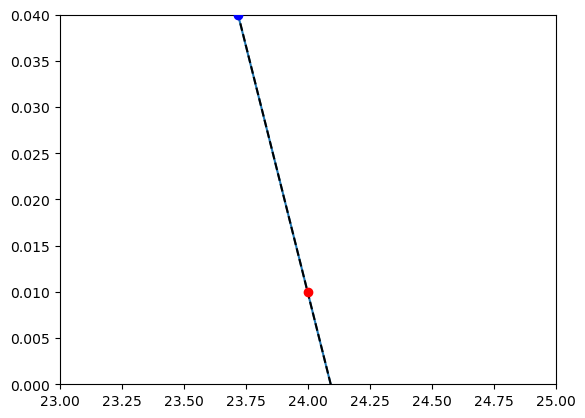

In [59]:
plt.plot(favata_vary_f(best_fit["x"][0], 10, 0.1, 24, e_line_vals), e_line_vals**2)
plt.scatter(x1, y1, c='r', zorder=5)
plt.scatter(x2, y2, c='b', zorder=5)
plt.plot(chirp_line_vals, e_line_vals**2, ls='dashed', c='k', zorder=4)
plt.xlim(23,25)
plt.ylim(0,0.2**2)

Can see here that to achieve the line we constructed above, we need to input a frequency of 30Hz (or equivalently eccentricity of 0.031) into the Favata et al. equation.

Let's try now to find the average eccentricity using 

$$
\overline{e} = \frac{4 \Re \int df \frac{e |h(f)|^2}{S(f)}}{4 \Re \int df \frac{|h(f)|^2}{S(f)}}
$$

In order to calculate the eccentricity at each frequency, we can use our orbital evolution equation, however this is not valid in the merger. We could set the high frequency cutoff to the ISCO frequency to solve this, however this would then ignore the merger completely. In absence of better solution will do this. Will also actually calculate average eccentricity squared, as this seems to be more useful quantity than eccentricity.

In [99]:
# Generate wf and psd
h = gen_wf(10, 0.1, chirp2total(24, 2), 2, 4096, 'TEOBResumS')
h.resize(ceiltwo(len(h)))
psd, _ = gen_psd(h, 10)
h = h.real().to_frequencyseries()

# Calculate both integrals with sigmasq
eccs = shifted_e(h.sample_frequencies, 10, 0.1)
ss = sigmasq(h, psd=psd, low_frequency_cutoff=13, high_frequency_cutoff=None)
ssee = sigmasq(h*eccs, psd=psd, low_frequency_cutoff=13, high_frequency_cutoff=None)

# Calculate average eccentricity
avg_e2 = ssee/ss
print(np.sqrt(avg_e2))

0.02273311276452316


This is close to what we want, but still not completely there.

Let's now overplot signal and psd in frequency domain to see if this reveals any insight.

Text(0, 0.5, 'Amplitude spectral density')

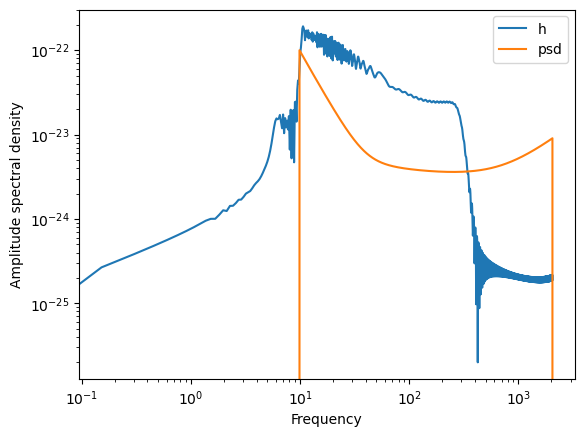

In [112]:
# Generate waveform and psd
h = gen_wf(10, 0.1, chirp2total(24, 2), 2, 4096, 'TEOBResumS')
psd, _ = gen_psd(h.real(), 7)
hp = h.real().to_frequencyseries()
hc = h.imag().to_frequencyseries()
h = hp-1j*hc

# Calculate amplitude spectral density
asd_h = 2*np.sqrt(h.sample_frequencies*h*h.conj())
asd_psd = np.sqrt(psd)

# Plot
plt.plot(h.sample_frequencies, asd_h/5000, label='h')
plt.plot(psd.sample_frequencies, asd_psd, label='psd')
plt.loglog()
plt.legend()
plt.xlabel('Frequency')
plt.ylabel('Amplitude spectral density')

Seems like our h waveform is much too large for the psd. Unsure whether this makes a difference in our calculation - suspect not as our equations for average frequency/eccentricity above always include a normalisation term.